In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizerFast
from collections import Counter
import re
import csv

import sklearn
from torch import nn
import numpy as np

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd

In [2]:
NUM_CLASSES = 6
NUM_SENTIMENT = 3
NUM_HATE = 2

BATCH_SIZE=32
EPOCHS=1

In [ ]:
trainDatasetPath = './train.csv'


class ToxicCommentsRobertaDataset(Dataset):
    def __init__(self, path, columnName, tokenizer, maxLength=512):
        """
        Args:
            path (string): Path to the csv file with annotations.
            columnName (string): Name of the column containing the comments.
            tokenizer: Tokenizer to use for tokenizing the comments.
            maxLength (int): Maximum length of the tokenized comments.
        """
        self.texts = []
        self.labels_list = []
        self.tokenizer = tokenizer
        self.maxLength = maxLength
        with open(path, encoding='utf-8') as f:
            reader = csv.reader(f)
            header = next(reader)
            textColIndex = header.index(columnName)
            labelColIndices = [
                header.index(label)
                for label in [
                    "toxic",
                    "severe_toxic",
                    "obscene",
                    "threat",
                    "insult",
                    "identity_hate",
                ]
            ]
            for rowIndex, row in enumerate(reader):
                text = row[textColIndex]
                # Aggregate labels: if any label is 1, the aggregated label is 1; otherwise, 0
                labels = any(
                    [int(row[labelColIndex]) for labelColIndex in labelColIndices]
                    # int(row[labelColIndex]) > 0  for labelColIndex in labelColIndices
                )

                self.texts.append(text)
                self.labels_list.append(labels)
        self.labels = torch.tensor(self.labels_list, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index: int):
        text = self.texts[index]
        labels = self.labels[index]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.maxLength,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": labels,
        }

In [4]:
class distilRB_base(nn.Module):
    def __init__(self, multilabel: bool=False):
        super(distilRB_base, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.activation = nn.Linear(self.base_model.config.hidden_size, NUM_CLASSES if multilabel else 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output
        y_hat = self.activation(pooled)
        return self.sigmoid(y_hat)

class distilRB_hate(nn.Module):
    def __init__(self, multilabel: bool=False):
        super(distilRB_hate, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.hate_model = AutoModelForSequenceClassification.from_pretrained("tomh/toxigen_roberta")
        #self.hate_model output for forward is a logit of size 2
        self.activation = nn.Linear(self.base_model.config.hidden_size + NUM_HATE, NUM_CLASSES if multilabel else 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output
        hate_signal = self.hate_model(input_ids, attention_mask)
        combined = torch.cat([pooled, hate_signal], dim=1)

        y_hat = self.activation(combined)
        return self.sigmoid(y_hat)


class distilRB_sem(nn.Module):
    def __init__(self, multilabel: bool=False):
        super(distilRB_sem, self).__init__()
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.sent_anal = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        #self.sentiment output for forward is a logit of size 3
        self.activation = nn.Linear(self.base_model.config.hidden_size + NUM_SENTIMENT, NUM_CLASSES if multilabel else 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output
        sentiment = self.sent_anal(input_ids, attention_mask)
        combined = torch.cat([pooled, sentiment], dim=1)
        y_hat = self.activation(combined)
        return self.sigmoid(y_hat)

class distilRB_combine(nn.Module):
    def __init__(self, multilabel: bool=False):
        self.base_model = AutoModel.from_pretrained("distilbert/distilroberta-base")
        self.sent_anal = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.hate_model = AutoModelForSequenceClassification.from_pretrained("tomh/toxigen_roberta")
        #self.sentiment output for forward is a logit of size 3
        self.activation = nn.Linear(
            self.base_model.config.hidden_size + NUM_SENTIMENT + NUM_HATE, NUM_CLASSES if multilabel else 1
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        inter = self.base_model(input_ids, attention_mask)
        pooled = inter.pooler_output
        sentiment = self.sent_anal(input_ids, attention_mask)
        hate = self.hate_model(input_ids, attention_mask)
        combined = torch.cat([pooled, sentiment, hate], dim=1)
        y_hat = self.activation(combined)
        return self.sigmoid(y_hat)


In [5]:
def trim(batch: dict[str, torch.tensor]):
    masks = batch['attention_mask']
    max_len = torch.max(torch.sum(masks, dim=1))

    if batch['labels'].shape == batch['input_ids'].shape:
        batch['labels'] = batch['labels'][:, :max_len]

    batch['input_ids'] = batch['input_ids'][:, :max_len]
    batch['attention_mask'] = batch['attention_mask'][:, :max_len]

    return batch

def train_model(model, dataset: Dataset, lr=1e-5, weight_decay=1e-3):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    optimizer = torch.optim.AdamW(lr=lr, weight_decay=weight_decay, params=model.parameters())


    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)
    loss_per_epoch = []

    criterion = torch.nn.BCELoss()

    model.train()
    for epoch in range(EPOCHS):
        losses = []
        for batch in train_dataloader:
            batch = trim(batch)

            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            # Cast labels to float16 before loss calculation
            labels = batch["labels"].to(device).type(torch.float16) # Changed line
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(**inputs).squeeze()


            loss = criterion(outputs, labels)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_per_epoch.append(losses)

    return loss_per_epoch

In [10]:
def evaluate_model(model, df, tokenizer, device='cuda'):
    model.to(device)
    model.eval()

    preds = []
    true_labels = []

    with torch.no_grad():
        for index in range(len(df)):
            text = df.iloc[index]['comment_text']
            label = df.iloc[index]['labels']

            encoding = tokenizer(
                text,
                add_special_tokens=True,
                max_length=512,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                return_tensors="pt",
            )

            inputs = {k: v.to(device) for k, v in encoding.items()}
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(**inputs).squeeze()

            # Sigmoid act so just check if >0.5
            pred = (outputs > 0.5).long()

            preds.append(pred.cpu().item())
            true_labels.append(label)

    f1 = sklearn.metrics.f1_score(true_labels, preds, average='binary')
    accuracy = sklearn.metrics.accuracy_score(true_labels, preds)
    precision = sklearn.metrics.precision_score(true_labels, preds)
    recall = sklearn.metrics.recall_score(true_labels, preds)

    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }

    return metrics

In [7]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_cached()/1024**2)


if __name__ == '__main__' :
    memory_stats()
    torch.cuda.empty_cache()
    memory_stats()
    tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
    toxicDataset = ToxicCommentsRobertaDataset(trainDatasetPath, 'comment_text', tokenizer=tokenizer)

    # if len(toxicDataset) > 0:
    #     print(f"\nLength of dataset: {len(toxicDataset)}")
    #     print(toxicDataset[1])
    # Instantiate the model you want to train (e.g., distilRB_base)
    model = distilRB_base(multilabel=False)


    # Train the model
    loss_per_epoch = train_model(model, toxicDataset)

    torch.cuda.empty_cache()

    # Evaluate the model
    # metrics = evaluate_model(model, dataset)

    # Print the evaluation metrics
    # print(metrics)

0.0
0.0
0.0
0.0


<ipython-input-7-14a431872c8d>:3: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(torch.cuda.memory_cached()/1024**2)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Error: User secrets cannot be accessed in agent mode. Learn more at https://research.google.com/colaboratory/faq.html#data-science-agent.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [12]:
df_test = pd.read_csv('test.csv', quotechar='"')
df_labels = pd.read_csv('test_labels.csv')

df_merged = pd.merge(df_test, df_labels, on='id', how='left')
df_merged['labels'] = 0

def aggregate_labels(row):
    if row['toxic'] == -1:
        return -1
    else:
        return int(row['toxic'] > 0 or row['severe_toxic'] > 0 or row['obscene'] > 0 or row['threat'] > 0 or row['insult'] > 0 or row['identity_hate'] > 0)

df_merged['labels'] = df_merged.apply(aggregate_labels, axis=1)
df_merged = df_merged.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)

df_filtered = df_merged[df_merged['labels'] != -1]
display(df_filtered.head())

label_counts = df_filtered['labels'].value_counts()
print(label_counts)

metrics = evaluate_model(model, df_filtered, tokenizer)
print(metrics)

,id,comment_text,labels
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0
7,000247e83dcc1211,:Dear god this site is horrible.,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0


labels
0    57735
1     6243
Name: count, dtype: int64
{'accuracy': 0.9283503704398387, 'precision': 0.5900358189514816, 'recall': 0.8707352234502643, 'f1': 0.703416149068323}


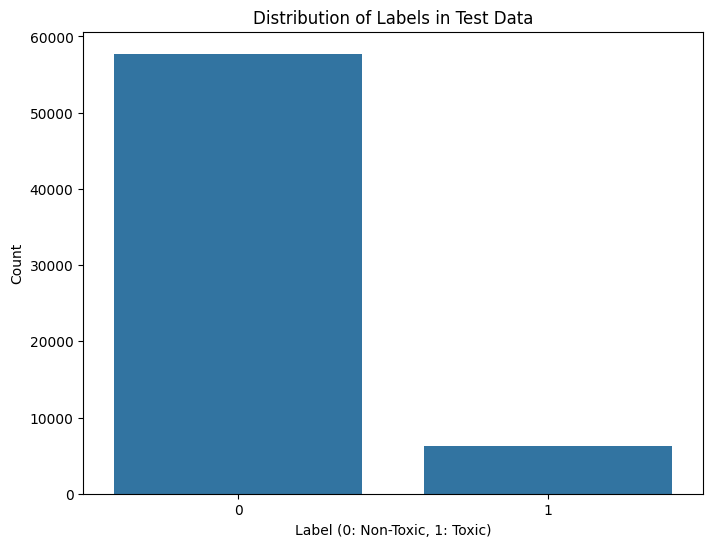

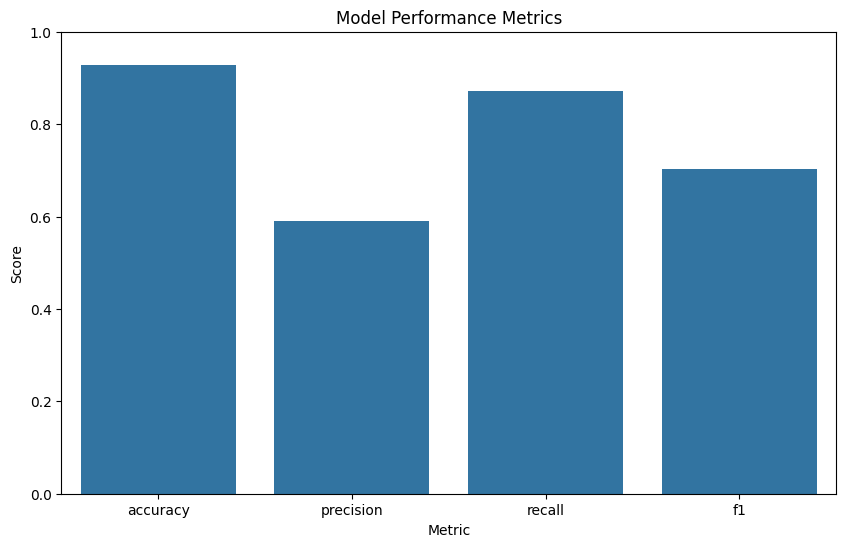

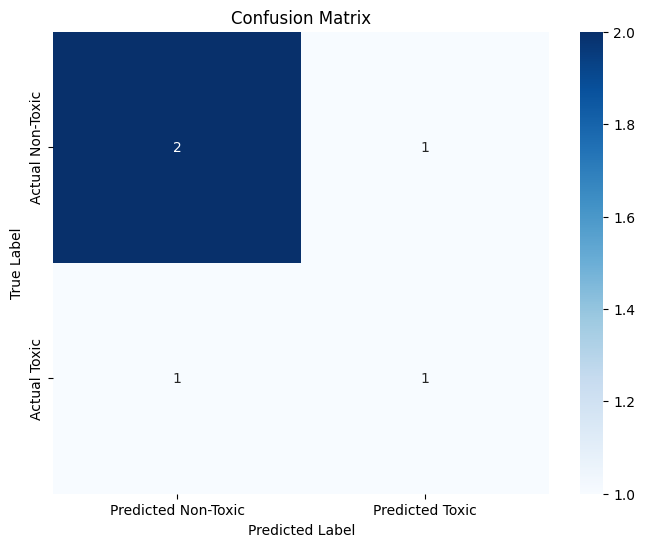

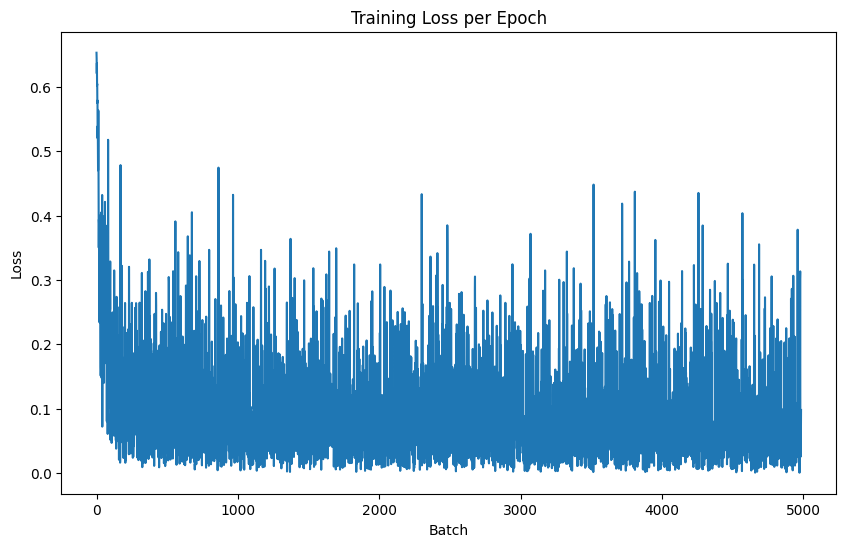

In [14]:
# prompt: generate some useful graphs and figures/tables for these eval results i have

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'metrics' and 'label_counts' are defined as in your provided code.

# 1. Bar plot for label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='labels', data=df_filtered)
plt.title('Distribution of Labels in Test Data')
plt.xlabel('Label (0: Non-Toxic, 1: Toxic)')
plt.ylabel('Count')
plt.show()

# 2. Metrics Visualization
metrics_df = pd.DataFrame([metrics])
metrics_df = metrics_df.T.reset_index()
metrics_df.columns = ['Metric', 'Value']


plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title('Model Performance Metrics')
plt.ylim(0, 1) # Assuming metrics are between 0 and 1
plt.ylabel('Score')
plt.show()


# 3. Confusion Matrix (requires predictions and true labels)

from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'preds' and 'true_labels' were saved during evaluation.
# Replace these with the actual predictions and true labels from evaluate_model
# preds = ...
# true_labels = ...

#Example
preds = [0, 1, 0, 1, 0]
true_labels = [0, 0, 1, 1, 0]

cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Toxic', 'Predicted Toxic'],
            yticklabels=['Actual Non-Toxic', 'Actual Toxic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4.  Loss Curve (if you saved the loss_per_epoch during training)

plt.figure(figsize=(10, 6))
for epoch_losses in loss_per_epoch:
    plt.plot(range(len(epoch_losses)), epoch_losses)
plt.title('Training Loss per Epoch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()
